In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# Creating custom legend handles
import matplotlib.lines as mlines
import sys
import os
import re
from tqdm import tqdm

def path_link(path:str):
    sys.path.append(path)

path_link('/master/code/lib')

import utils.stats as stats
import utils.testing_gen as gen
import utils.loading as load
import utils.nn_gen as nn_gen
from utils.tools import array2List, writeJson

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [21]:
#PATH = ['/master/code/last/finished_exps/simplest']
PATH = ['/master/code/results/models/noisy/0-001/delta']

PATH_DISPLAY = '/master/code/results/ablation/pySr_stuff'

In [22]:
class id():
    def __init__(self):
        self.dropout = None
        self.l1 = None
        self.path = None
        self.loss = None
        self.eval_loss = None
        self.eval_sim_loss = None
        self.data_type = None
        self.action_r = None
        self.cfg = None


    def load_id(self, path:str):
        try:
            if 'scaleL1' in path:
                nb_layer_match = re.search(r'scaleL1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))


            if 'l1' in path:
                nb_layer_match = re.search(r'l1-(\d+\.\d+|\d+)', path)
                self.l1 = float(nb_layer_match.group(1))

            if 'dropout' in path:
                try:
                    dropout_match = re.search(r'dropout-(\d+)', path)
                    self.dropout = int(dropout_match.group(1))
                except:
                    self.dropout = 0





            if 'action' in path:
                self.action_r = 1
            else:
                0




            

            if 'noisy' in path:
                self.data_type = 'noisy'

            elif 'normal' in path:
                self.data_type = 'normal'
            
            
            self.path = path

            self.loss = os.path.join(os.path.dirname(path), 'loss_list.npy')
            self.eval_loss = os.path.join(os.path.dirname(path), 'eval_list.npy')
            self.eval_sim_loss = os.path.join(os.path.dirname(path), 'eval_sim_list.npy')
            self.cfg = os.path.join(os.path.dirname(os.path.dirname(path)), 'cfg.yml')

        except:
            print(path)

    def label(self):
        return f'{self.data_type}_action-{self.action_r}_dropout{self.dropout}_l1-{self.l1}'

In [23]:
def get_path_models(path):

    res = []

    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('best.pt'):
                id_model = id()
                id_model.load_id(os.path.join(root, file))

                res.append(id_model)


    return res

In [24]:
def get_path_mdoels(ids_list, path_display_base):

    model_list = []
    path_display_list = []
    cfg_list = []

    for id in ids_list:
        path = id.path
        name = id.label()
        config = id.cfg


        model_list.append(path)
        path_display_list.append(os.path.join(path_display_base, name))
        cfg_list.append(config)

    return model_list, path_display_list, cfg_list
        

In [25]:
res = []

for path in PATH:
    res.extend(get_path_models(path))


for r in res:
    print(f'{r.path} >>> {r.__dict__}')


models_list, paths_list, cfg_list = get_path_mdoels(res, PATH_DISPLAY)

/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/model_trained/simplest_no-dropout_no-encoder_best.pt >>> {'dropout': 0, 'l1': 0.0001, 'path': '/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/model_trained/simplest_no-dropout_no-encoder_best.pt', 'loss': '/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/model_trained/loss_list.npy', 'eval_loss': '/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/model_trained/eval_list.npy', 'eval_sim_loss': '/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/model_trained/eval_sim_list.npy', 'data_type': 'noisy', 'action_r': None, 'cfg': '/master/code/results/models/noisy/0-001/delta/mt_noisy_dType-delta_dt-0.001_lr-0.001_l1-0.0001_batch-32_end/cfg.yml'}
/master/c

# ========================

generate some data

In [26]:
def getParams():
    params = gen.Parameters_Simulation()  


    params.dt = 0.001
    params.v0 = 60
    params.k = 70
    params.epsilon = 0.5
    params.tau = 3.5
    params.R = 1
    params.N = 200
    params.boundary = 100
    params.nbStep = 300


    params.noisy = 1        # function dans utils
    params.features_x = 'delta'
    params.features_edge = 'first'


    return params

In [27]:
NB_SIM = 2

params = getParams()                # adapt ...
data_gt = gen.get_mult_data(params, NB_SIM)
graphs_gt = gen.sims2Graphs(data_gt, params.features_x)

1
v0:60, tau:3.5, k:70, epsilon:0.5
0.14285714285714285
1


100%|██████████| 299/299 [00:02<00:00, 104.64it/s]


1
v0:60, tau:3.5, k:70, epsilon:0.5
0.14285714285714285
1


100%|██████████| 299/299 [00:02<00:00, 109.88it/s]


# ==============

Create folder, get messages, 
- plot the messages, 
- the bar plot of the most used message features and 
- the scatter plot of the interaction intensity wrt most significant message

In [28]:
#MODEL_PATH = '/master/code/last/models'
MODEL_PATH = '/master/code/models'

#MODEL = 'baseline'
#MODEL = 'simplest'
MODEL = 'simplest_no-dropout_no-encoder'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
import yaml
from utils.pysr_help import getPrediction, getEdges, getGroundTruth

In [29]:
def loadModel(modelName:str, d, path = MODEL_PATH):
    """ 
    Function to import the model

    Args:
    -----
        - `modelName`: name of the model
        - `inputShape`: inout shape of the NN
        - `edges_shape`: edge shape of the NN
        - `path`: path where the models are
    """

    sys.path.append(path)

    loadFun = __import__(f'{modelName}', fromlist = ('loadNetwork'))

    #model = loadFun.loadNetwork(inputShape, edges_shape)
    model = loadFun.loadNetwork(d)

    return model


def getModel(cfg, std_path, device = DEVICE, model_path = MODEL_PATH):

    with open(cfg, 'r') as file:
        cfg = yaml.safe_load(file) 

    trainingInfos = cfg['training']

    try:
        d_model = trainingInfos['cfg_mod'][f'{trainingInfos["cfg_mod"]["model_name"]}']
    except:
        d_model = None
        print('Exception d_model')

    model = loadModel(MODEL, d_model, model_path)



    state_dict = torch.load(std_path, map_location = 'cpu')

    model.load_state_dict(state_dict)

    model.eval()

    model = model.to(device)

    return model

    

In [30]:
def get_message(model, attr):
    model.eval()
    with torch.no_grad():
        v = model.GNN.message(None, None, attr).cpu().detach().numpy()
    return v

In [31]:
def plotStdMessage(messages, path):

    std = np.std(messages, axis = 0)

    plt.bar(np.arange(std.shape[0]), std, color = 'blue')
    
    plt.ylabel('Std of the messages')
    plt.xlabel('Features of the messages')
    plt.xticks(rotation=90)
    plt.ylim([np.min(std) - 0.001, np.max(std) + 0.001])
    plt.tight_layout()
    plt.savefig(path)

    return std

In [32]:
def plot_scatter_messages(messages, data, path, nb_messages = 5):
    edges = getEdges(data)

    std_messages = np.std(messages, axis = 0)
    inds = np.argsort(std_messages)
    inds = np.flip(inds[-nb_messages:])

    names = ['Distance', 'Cosine', 'Sine', 'Radius 1', 'Radius 2']

    for i in range(edges.shape[1]):
        path_scatter = os.path.join(path, names[i])

        print(path_scatter)
        if not os.path.exists(path_scatter):
            os.makedirs(path_scatter)

        for j in range(len(inds)):
            indice_j = inds[j]

            plt.scatter(edges[:, i], messages[:, indice_j])
            plt.xlabel(names[i])
            plt.ylabel('Message')
            plt.savefig(os.path.join(path_scatter, f'{names[i]}-{j}.png'))
            plt.close()

In [33]:
def plot_scatter_intens(graphs_gt, messages, path, nb_messages = 5, k=70, epsilon = 0.5):

    std_messages = np.std(messages, axis = 0)
    inds = np.argsort(std_messages)
    inds = np.flip(inds[-nb_messages:])

    interact_norm = getGroundTruth(graphs_gt, k=70, epsilon = 0.5)

    for i in range(nb_messages):
        path_scat = os.path.join(path, f'nb-{i} - x.png')
        index_message = inds[i]

        
        plt.scatter(messages[:, index_message], interact_norm[:, 0], alpha=0.4, zorder = 2)
        plt.xlabel('Message')
        plt.ylabel('Interaction - x')
        plt.grid(zorder = 1)
        plt.savefig(path_scat)
        plt.close()


        path_scat = os.path.join(path, f'nb-{i} - y.png')

        
        plt.scatter(messages[:, index_message], interact_norm[:, 1], alpha=0.4, zorder = 2)
        plt.xlabel('Message')
        plt.ylabel('Interaction - y')
        plt.grid(zorder = 1)
        plt.savefig(path_scat)
        plt.close()
        


In [34]:
print(MODEL)

simplest_no-dropout_no-encoder


In [35]:
def get_linear_predictions(X, Y):

    resMod = []
    pred = []
    for i in range(Y.shape[1]):
        model = LinearRegression()
        model.fit(X, Y[:, i])

        y_pred = model.predict(X)

        pred.append(y_pred)
        resMod.append(model)


    return resMod, np.column_stack(pred)

def get_R2_score(messages, graphs_gt, nb_messages = 2):
    std_messages = np.std(messages, axis = 0)
    inds = np.argsort(std_messages)
    inds = np.flip(inds[-nb_messages:])

    model = LinearRegression()

    messages_2 = messages[:, inds]

    interact_norm = getGroundTruth(graphs_gt, k=70, epsilon = 0.5)

    model = model.fit(messages_2, interact_norm)

    score = r2_score(interact_norm, model.predict(messages_2))

    return score


    

In [36]:
for i in tqdm(range(len(models_list))):

    model_st_dict = models_list[i]
    cfg = cfg_list[i]
    path = paths_list[i]

    model = getModel(cfg, model_st_dict)

    mdoel = model.to('cpu')
    
    messages = getPrediction(model, graphs_gt)


    # create folder

    if not os.path.exists(path):
        os.makedirs(path)

    # create std bar plot

    plotStdMessage(messages, os.path.join(path, 'std_messages.png'))
    plt.close()

    # plot scatter messages

    if not os.path.exists(os.path.join(path, 'features')):
        os.makedirs(os.path.join(path, 'features'))
        
    plot_scatter_messages(messages.copy(), graphs_gt, os.path.join(path, 'features'), nb_messages = 2)

    # plot scatter loargest

    if not os.path.exists(os.path.join(path, 'scatter_rot')):
        os.makedirs(os.path.join(path, 'scatter_rot'))

    plot_scatter_intens(graphs_gt, messages.copy(), os.path.join(path, 'scatter_rot'), nb_messages = 2, k=70, epsilon = 0.5)


    # r2 score

    r2 = get_R2_score(messages.copy(), graphs_gt, nb_messages=2)

    d = {}
    d[f'r2_score_{path}'] = r2
    writeJson(d, os.path.join(path, 'r2.json'))



  0%|          | 0/4 [00:00<?, ?it/s]

Exception d_model
>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.0001/features/Distance
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.0001/features/Cosine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.0001/features/Sine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.0001/features/Radius 1
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.0001/features/Radius 2


 25%|██▌       | 1/4 [00:25<01:17, 25.88s/it]

Exception d_model
>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.001/features/Distance
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.001/features/Cosine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.001/features/Sine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.001/features/Radius 1
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.001/features/Radius 2


 50%|█████     | 2/4 [00:53<00:54, 27.13s/it]

Exception d_model
>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.01/features/Distance
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.01/features/Cosine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.01/features/Sine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.01/features/Radius 1
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-0.01/features/Radius 2


 75%|███████▌  | 3/4 [01:17<00:25, 25.41s/it]

Exception d_model
>>>> loading simplest
INFO >>> with NO encoder
INFO >>> with NO dropout
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-1.0/features/Distance
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-1.0/features/Cosine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-1.0/features/Sine
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-1.0/features/Radius 1
/master/code/results/ablation/pySr_stuff/noisy_action-None_dropout0_l1-1.0/features/Radius 2


100%|██████████| 4/4 [01:39<00:00, 24.95s/it]


In [ ]:
print(messages.shape)
interact_norm = getGroundTruth(graphs_gt, k=70, epsilon = 0.5)
print(interact_norm.shape)

(858826, 128)
(858826, 2)


In [ ]:
std_messages = np.std(messages, axis = 0)
inds = np.argsort(std_messages)
inds = np.flip(inds[-2:])

Text(0.5, 0, 'Message x')

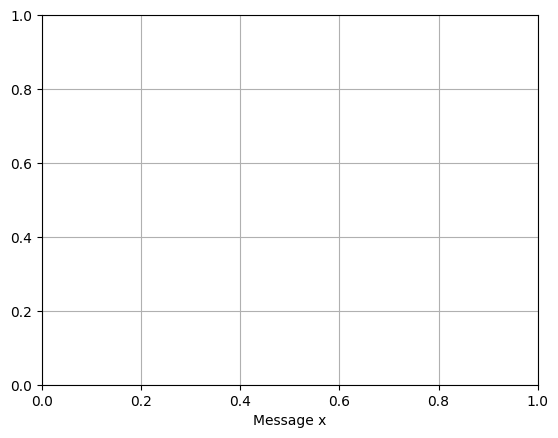

In [19]:
plt.grid(zorder = 1)
plt.xlabel("Message x")

In [18]:
plt.scatter(messages[:, inds[1]], interact_norm[:, 0], zorder = 2)
plt.grid(zorder = 1)
plt.xlabel("Message x")

NameError: name 'inds' is not defined

In [ ]:
model = LinearRegression()

model = model.fit(messages[:, inds], interact_norm)

score = r2_score(interact_norm, model.predict(messages[:, inds]))

print(score)

0.7810496091842651


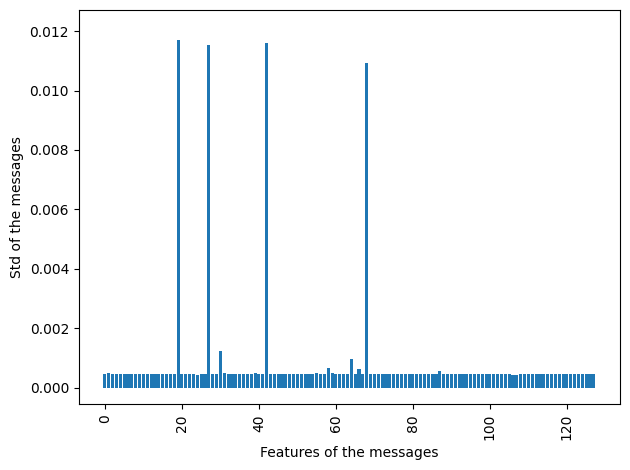

In [ ]:
std = np.std(messages, axis = 0)

plt.bar(np.arange(std.shape[0]), std)

plt.ylabel('Std of the messages')
plt.xlabel('Features of the messages')
plt.xticks(rotation=90)
plt.ylim([np.min(std) - 0.001, np.max(std) + 0.001])
plt.tight_layout()